<td>
    <a target="_blank" href="https://colab.research.google.com/github/jjerry-k/learning_framework/blob/main/02_Intermediate/Simple_Convolutional_Neural_Network/PyTorch.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>

In [1]:
# Importing Modules
import os
import random
from tqdm import tqdm

import numpy as np
from PIL import Image

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader 

from torchvision import transforms

from matplotlib import pyplot as plt

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set randomness
seed = 777
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set hyperparameter
epochs= 5
batch_size= 16
img_size= 192

In [2]:
# Dataset
class FlowerDataset(Dataset):
    def __init__(self, data_dir, transform):
        IMG_FORMAT = ["jpg", "jpeg", "bmp", "png", "tif", "tiff"]
        self.filelist = []
        self.classes = sorted(os.listdir(data_dir))
        for root, _, files in os.walk(data_dir):
            if not len(files): continue
            files = [os.path.join(root, file) for file in files if file.split(".")[-1] in IMG_FORMAT]
            self.filelist += files
        # self.filelist = self.filelist[:64]
        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.filelist)

    def __getitem__(self, idx):

        image = Image.open(self.filelist[idx]).convert("RGB")
        image = self.transform(image)
        label = self.filelist[idx].split('/')[-2]
        label = self.classes.index(label)
        return image, label

transform = transforms.Compose([
                                transforms.Resize((img_size, img_size)), transforms.ToTensor()
                                ])
train_dataset = FlowerDataset(os.path.join("../../../data/flower_photos/train"), transform)
val_dataset = FlowerDataset(os.path.join("../../../data/flower_photos/validation"), transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [3]:
# Defining Model
class InceptionModule(nn.Module):
    def __init__(self, input_feature, 
                filters_b1, filters_b2_1, filters_b2_2, 
                filters_b3_1, filters_b3_2, filters_b4):
        super(InceptionModule, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(input_feature, filters_b1, 1), 
            nn.ReLU(True))

        self.branch2 = nn.Sequential(
            nn.Conv2d(input_feature, filters_b2_1, 1),
            nn.ReLU(True),
            nn.Conv2d(filters_b2_1, filters_b2_2, 3, 1, 1),
            nn.ReLU(True)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(input_feature, filters_b3_1, 1),
            nn.ReLU(True),
            nn.Conv2d(filters_b3_1, filters_b3_2, 5, 1, 2),
            nn.ReLU(True)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(3, 1, 1),
            nn.Conv2d(input_feature, filters_b4, 1),
            nn.ReLU(True)
        )

    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], dim=1)

class AuxiliaryClassifier(nn.Module):
    def __init__(self, input_feature, num_classes):
        super(AuxiliaryClassifier, self).__init__()
        self.block = nn.Sequential(
            nn.AvgPool2d(5, 3, 1),
            nn.Conv2d(input_feature, 128, 1),
            nn.ReLU(True),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        return self.block(x)

        
class GoogLeNet(nn.Module):
    def __init__(self, input_channel=3, num_classes=1000):
        super(GoogLeNet, self).__init__()

        self.Stem = nn.Sequential(
            nn.ZeroPad2d(3),
            nn.Conv2d(input_channel, 64, 7, 2),
            nn.ReLU(True),
            nn.MaxPool2d(3, 2),
            nn.LocalResponseNorm(64),
            nn.Conv2d(64, 64, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 192, 3, 1, 1),
            nn.ReLU(True),
            nn.LocalResponseNorm(192),
            nn.MaxPool2d(3, 2)
        )
        
        self.pool = nn.MaxPool2d(3, 2)

        self.inception1 = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception2 = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.inception3 = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.aux1 = AuxiliaryClassifier(512, num_classes)
        self.inception4 = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception5 = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception6 = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.aux2 = AuxiliaryClassifier(528, num_classes)
        self.inception7 = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.inception8 = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception9 = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(1024, num_classes)
        )

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        x = self.Stem(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.pool(x)
        
        x = self.inception3(x)
        aux1 = self.aux1(x)

        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        aux2 = self.aux2(x)
        
        x = self.inception7(x)
        x = self.pool(x)

        x = self.inception8(x)
        x = self.inception9(x)

        x = self.classifier(x)
        return x, aux1, aux2

model = GoogLeNet(input_channel=3, num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [4]:
# Training
for epoch in range(epochs):
    model.train()
    avg_loss = 0
    avg_acc = 0
    
    with tqdm(total=len(train_loader)) as t:
        t.set_description(f'[{epoch+1}/{epochs}]')
        total = 0
        correct = 0
        for i, (batch_img, batch_lab) in enumerate(train_loader):
            X = batch_img.to(device)
            Y = batch_lab.to(device)

            y_pred, aux_1, aux_2 = model.forward(X)

            loss = criterion(y_pred, Y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

            _, predicted = torch.max(y_pred.data, 1)
            total += Y.size(0)
            correct += (predicted == Y).sum().item()
            
            t.set_postfix({"loss": f"{avg_loss/(i+1):05.3f}"})
            t.update()
        acc = (100 * correct / total)

    model.eval()
    with tqdm(total=len(val_loader)) as t:
        t.set_description(f'[{epoch+1}/{epochs}]')
        with torch.no_grad():
            val_loss = 0
            total = 0
            correct = 0
            for i, (batch_img, batch_lab) in enumerate(val_loader):
                X = batch_img.to(device)
                Y = batch_lab.to(device)
                y_pred, aux_1, aux_2 = model(X)
                val_loss += criterion(y_pred, Y)
                _, predicted = torch.max(y_pred.data, 1)
                total += Y.size(0)
                correct += (predicted == Y).sum().item()
                t.set_postfix({"val_loss": f"{val_loss.item()/(i+1):05.3f}"})
                t.update()

            val_loss /= len(val_loader)
            val_acc = (100 * correct / total)
            
    print(f"Epoch : {epoch+1}, Loss : {(avg_loss/len(train_loader)):.3f}, Acc: {acc:.3f}, Val Loss : {val_loss.item():.3f}, Val Acc : {val_acc:.3f}\n")

print("Training Done !")

[1/5]: 100%|██████████| 24/24 [00:01<00:00, 20.14it/s, val_loss=1.325]


Epoch : 1, Loss : 1.489, Acc: 32.657, Val Loss : 1.325, Val Acc : 38.753



[2/5]: 100%|██████████| 24/24 [00:01<00:00, 19.93it/s, val_loss=1.292]


Epoch : 2, Loss : 1.317, Acc: 40.745, Val Loss : 1.292, Val Acc : 41.192



[3/5]: 100%|██████████| 24/24 [00:01<00:00, 19.37it/s, val_loss=1.231]


Epoch : 3, Loss : 1.264, Acc: 44.199, Val Loss : 1.231, Val Acc : 46.070



[4/5]: 100%|██████████| 24/24 [00:01<00:00, 19.41it/s, val_loss=1.140]


Epoch : 4, Loss : 1.186, Acc: 48.167, Val Loss : 1.140, Val Acc : 50.949



[5/5]: 100%|██████████| 24/24 [00:01<00:00, 19.53it/s, val_loss=1.148]

Epoch : 5, Loss : 1.151, Acc: 50.591, Val Loss : 1.148, Val Acc : 48.509

Training Done !


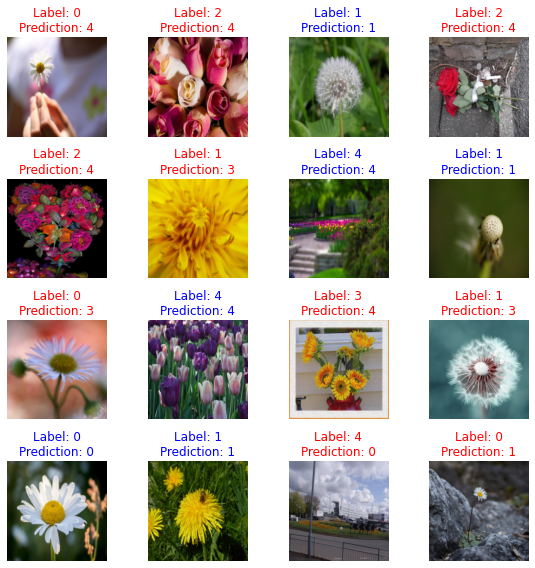

In [5]:
# Sample
for images, labels in val_loader:
    break

num_sample = len(images)
col = int(np.ceil(np.sqrt(num_sample)))
row = int(np.ceil(num_sample/col))

idx = np.random.randint(0, len(val_dataset), num_sample)

sample_image = images.to(device)
sample_label = labels
prediction, _, _ = model(sample_image)
prediction = torch.argmax(prediction, dim=1).cpu().detach()

plt.figure(figsize=(col*2, row*2))
for i in range(num_sample):
    plt.subplot(row, col, i+1)
    color = "blue" if prediction[i] == sample_label[i] else "red"
    plt.imshow(sample_image[i].permute(1, 2, 0).cpu())
    plt.title(f"Label: {sample_label[i]}\nPrediction: {prediction[i]}", color=color, fontsize=12)
    plt.axis("off")
plt.tight_layout()
plt.show()